#Gates

In [139]:
import numpy as np

class Gate:
    def forward(self):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError

class AddGate(Gate):
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y
    def backward(self, dz):
        dx = dz * np.ones_like(self.x)
        dy = dz * np.ones_like(self.y)
        return dy

class MultiplyGate:
    def forward(self, x, y):
        self.x = x
        self.y = y
        return np.dot(x, y)

    def backward(self, dz):
        dz=dz.reshape(self.x.shape[0],1)
        self.y=self.y.reshape(self.y.shape[0],1)

        dx = np.dot(dz, self.y.T)
        dy = np.dot(self.x.T, dz)
        return dx, dy

#Activation functions

In [140]:
class SoftmaxActivation(Gate):
    def forward(self, x):
        self.x = x
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def backward(self, dz):
        softmax_x = self.forward(self.x)
        dx = dz * softmax_x * (1 - softmax_x)
        return dx

class SigmoidActivation(Gate):
    def forward(self, x):
        self.x = x
        if x >= 0:
          self.sig =  1. / ( 1. + np.exp(-x) )
        else:
          self.sig =  np.exp(x) / ( 1. + np.exp(x) )
        print(f"self.sig = {self.sig}")
        return self.sig

    def backward(self, dz):
        dx = dz * self.sig * (1 - self.sig)
        return dx

class ReLUActivation(Gate):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dz):
        print(f"ReLU.x = {self.x}")
        dx = dz * np.where(self.x > 0, 1, 0)
        return dx

#Loss functions

In [141]:
class BinaryCrossEntropyLoss(Gate):
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred.flatten()
        epsilon = 1e-7
        self.y_pred = np.clip(self.y_pred, epsilon, 1 - epsilon)
        self.y_true = y_true
        return -np.mean(self.y_true * np.log(self.y_pred) + (1 - self.y_true) * np.log(1 - self.y_pred))

    def backward(self):
        #dy_pred = - (self.y_true / self.y_pred) + ((1 - self.y_true) / (1 - self.y_pred))
        dy_pred = (self.y_pred - self.y_true) / (self.y_pred * (1 - self.y_pred))
        return dy_pred

class L2Loss(Gate):
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return 0.5 * np.mean((y_pred - y_true) ** 2)

    def backward(self,y_pred, y_true):
        dx = y_pred - y_true
        return dx

#My Model

In [142]:
class my_Model:
  def __init__(self,layers_dim, actiation_func, loss):
    self.layers=[]
    self.layers_dim = layers_dim
    self.num_layers=len(layers_dim)
    self.grads=[]
    self.weightsgrads=[]
    self.biasgrads=[]

    if len(layers_dim)!=len(actiation_func)+1:
      raise ValueError("the number of layers is not equal to the number of activation funcs")
    for i in range(0,self.num_layers - 1):
      layer=[]
      layer.append(MultiplyGate())
      layer.append(AddGate())

      if actiation_func[i] =='sigmoid':
        layer.append(SigmoidActivation())
      if actiation_func[i] =='relu':
        layer.append(ReLUActivation())
      if actiation_func[i] =='softmax':
        layer.append(SoftmaxActivation())

      self.layers.append(layer)

    if loss=='CE':
      self.loss=BinaryCrossEntropyLoss()
    elif loss=='L2':
      self.loss=L2Loss()
    self.parameters=self.initialise_parameters()

  def initialise_parameters(self):
    parameters = []
    for i in range(1, self.num_layers):
      weights = np.random.randn(self.layers_dim[i], self.layers_dim[i-1])
      biases = np.random.randn(self.layers_dim[i])
      layer_param = {'weights': weights, 'biases': biases}
      parameters.append(layer_param)
    return parameters

  def forward(self, x):
    for i in range(0,self.num_layers-1):
      x = self.layers[i][0].forward(self.parameters[i]['weights'], x)
      #print(f"Layer {i+1},After multip: {x}")
      x = x.flatten()
      x = self.layers[i][1].forward(x, self.parameters[i]['biases'])
      #print(f"Layer {i+1},After addition: {x}")
      x = self.layers[i][2].forward(x)
      #print(f"Layer {i+1},After activation: {x}")
    return(x)

  def predict(self, X):
    y_pred = []
    X = np.array(X)
    if not isinstance(X[0], np.ndarray):
      y = self.forward(X)
      y_pred.append(y)

    else:
      for i in range(len(X)):
        y = self.forward(X[i])
        y_pred.append(y)
    y_pred = np.array(y_pred)
    return (y_pred)

  def backward(self, computed_loss):
    self.grads.append(computed_loss)
    dz = computed_loss #upstream gradient of last activation function
    for i in range(self.num_layers - 2, -1, -1):
      print(f"layer {i + 1}")
      dz = self.layers[i][2].backward(dz)
      print(f"upstream grad of layer activation function = {dz}")
      db = self.layers[i][1].backward(dz)
      print(f"bias grad = {db}")
      dw, dz = self.layers[i][0].backward(dz)
      print(f"weights grad = {dw}")
      print(f"upstream grad of next layer = {dz}")

      self.weightsgrads.append(dw)
      self.biasgrads.append(db)
      self.grads.append(dz)


  def train(self, X_train, Y_train, learning_rate, num_epochs, gradient_descent_method='batch',batch_size=None,patience=10):
    ss=[]
    for i in range (0,num_epochs):

      print(f"\nEpoch {i+1}:")
      if gradient_descent_method=='batch':
        y_pred=self.predict(X_train)
        loss=self.loss.forward(y_pred,Y_train)
        print(f"loss = {loss}")
        print("Starting back propagation")
        computed_loss=self.loss.backward()
        computed_loss=np.array(computed_loss)
        computed_loss=np.mean(computed_loss)
        print(f"upstream gradient of layer 2 func = {computed_loss}")
        self.backward(computed_loss)

        self.update_parameters(learning_rate)
        ss.append(loss)

  def update_parameters(self,learning_rate):
    parameters=[]
    for i in range(0,len(self.parameters)):
      #print(f"old weights = {self.parameters[i]['weights'][0]}]")
      w=self.parameters[i]['weights']-learning_rate*self.weightsgrads[len(self.parameters)-i-1]
      print(f"new weights of layer {i+1} = {w[0]}")

      # print("output",self.parameters[i]['weights'].shape)
      s=np.array(self.biasgrads[len(self.parameters)-i-1])
      b=self.parameters[i]['biases']-learning_rate*s
      layer_param = {'weights': w, 'biases': b}
      parameters.append(layer_param)
    self.parameters=parameters

#Model

In [143]:
from sklearn.metrics import accuracy_score, mean_squared_error
class Model:
    def __init__(self,layers_dim, actiation_func, loss):
        self.layers=[]
        self.activFunc=[]
        self.layers_dim = layers_dim
        self.num_layers=len(layers_dim)
        self.grads=[]
        self.weightsgrads=[]
        self.biasgrads=[]
        self.stop_count=0

        if len(layers_dim)!=len(actiation_func)+1:
            raise ValueError("the number of layers is not equal to the number of activation funcs")
        for i in range(0,len(layers_dim)-1):
            layer=[]
            layer.append(MultiplyGate())
            layer.append(AddGate())
            self.layers.append(layer)
        for i in range(0,len(actiation_func)):
            if actiation_func[i] =='sigmoid':
                self.activFunc.append(SigmoidActivation())
            if actiation_func[i] =='relu':
                self.activFunc.append(ReLUActivation())
            if actiation_func[i] =='softmax':
                self.activFunc.append(SoftmaxActivation())
        if loss=='CE':
            self.loss=BinaryCrossEntropyLoss()
        elif loss=='L2':
            self.loss=L2Loss()
        self.parameters=self.initialise_parameters()

    def initialise_parameters(self):
        parameters = []
        for i in range(1, len(self.layers_dim)):
            weights = np.random.rand(self.layers_dim[i],self.layers_dim[i-1])
            biases = np.random.rand(self.layers_dim[i])
            layer_param = {'weights': weights, 'biases': biases}
            parameters.append(layer_param)
        return parameters

    def forward(self, x):
        for i in range(0,self.num_layers-1):
            x = self.layers[i][0].forward(self.parameters[i]['weights'],x)
            x = x.flatten()
            x = self.layers[i][1].forward(x, self.parameters[i]['biases'])
            x = self.activFunc[i].forward(x)

        return(x)

    def backward(self,losscomputed):
        dy = losscomputed
        self.grads.append(dy)
        dz = dy #upstream gradient of last activation function
        for i in range(self.num_layers-1, 0, -1):
            print(f"Flayer no {i+1}")
            dz = self.activFunc[i-1].backward(dz)
            dz = dz.flatten()
            if len(dz)==1:
                dz=dz[0]
            print(f"dz = {dz}")
            db = self.layers[i-1][1].backward(dz)
            dw,dz = self.layers[i-1][0].backward(dz)
            self.weightsgrads.append(dw)
            dz=dz.flatten()
            self.biasgrads.append(db)
            print(f"weight gradients = {dw}")
            print(f"bias gradients = {db}")
            self.grads.append(dz)

    def train(self, X_train, Y_train, learning_rate, num_epochs, gradient_descent_method='batch',batch_size=None,patience=10):
        ss=[]
        learning_rate_sch = LearningRateScheduler('cosine', learning_rate, num_epochs)
        for i in range (0,num_epochs):
            self.dropout()
            if gradient_descent_method=='batch':
                y_pred=self.predict(X_train)
                loss=self.loss.forward(y_pred,Y_train)
                # print(loss)
                computed_loss=self.loss.backward()
                computed_loss=np.array(computed_loss)
                computed_loss=np.mean(computed_loss)
                # print(computed_loss)

                self.backward(computed_loss)

                self.update_parameters(learning_rate)
                ss.append(loss)
                # print(loss)
                if self.check_early_stopping(ss):
                    break

            if gradient_descent_method=='stocastic_batch':
                for j in range (0,len(X_train)):
                    sample=[]
                    sample.append(X_train[j])
                    lr=0.1*self.learning_rate
                    y_pred=self.predict(sample)
                    loss=self.loss.forward(y_pred,Y_train[j])
                    # print(loss)
                    computed_loss=self.loss.backward()
                    computed_loss=np.array(computed_loss)
                    computed_loss=np.mean(computed_loss)
                    # print(computed_loss)
                    self.backward(computed_loss)
                    self.update_parameters(lr)
                    
                    if j==len(X_train)-1:
                        ss.append(loss)
            if gradient_descent_method=='mini_batch':
                loss=0
                for j in range (0,len(X_train)//batch_size):
                    samples=[]
                    labels=[]
                    for k in range (0,batch_size):
                        samples.append(X_train[batch_size*j+k])
                        labels.append(Y_train[batch_size*j+k])
                    y_pred=self.predict(samples)
                    loss=self.loss.forward(y_pred,labels)
                    # print(loss)
                    computed_loss=self.loss.backward()
                    computed_loss=np.array(computed_loss)
                    computed_loss=np.mean(computed_loss)
                    # print(computed_loss)
                    self.backward(computed_loss)

                    self.update_parameters(learning_rate)
                ss.append(loss)


            learning_rate = learning_rate_sch.update_learning_rate(current_epoch=i + 1)
            

        return ss
    def check_early_stopping(self,loss):
        if len(loss)>2:
            if loss[-2]<loss[-1]:
                self.stop_count+=1
            else:
                self.stop_count=0
        if self.stop_count>10:
            return True
        return False

    def dropout(self):
        for i in range(0,len(self.parameters)):
            for j in range(0,(self.parameters[i]['weights'].shape[0])):
                for k in range(0,(self.parameters[i]['weights'].shape[1])):
                
                    if np.random.randn(0,5)<0.2:
                        self.parameters[i]['weights'][j][k]=0
                if np.random.randn(0,5)<0.2:
                    self.parameters[i]['biases'][j]=0

        
        pass
    def update_parameters(self,learning_rate):
        parameters=[]
        for i in range(0,len(self.parameters)):
            #print(f"old weights = {self.parameters[i]['weights'][0]}]")
            w=self.parameters[i]['weights']-learning_rate*self.weightsgrads[len(self.parameters)-i-1]
            print(f"new weights of layer {i+1} = {w[0]}")

            # print("output",self.parameters[i]['weights'].shape)
            s=np.array(self.biasgrads[len(self.parameters)-i-1])
            b=self.parameters[i]['biases']-learning_rate*s
            layer_param = {'weights': w, 'biases': b}
            parameters.append(layer_param)
        self.parameters=parameters

    def predict(self, X):
        y_pred=[]
        for i in range(0,len(X)):
            y=self.forward(X[i])
            y_pred.append(y)
        y_pred=np.array(y_pred)
        return (y_pred)

    def score(self, X, y_true):
      y_pred = self.predict(X)

      if self.activFunc[-1] == 'sigmoid' or self.activFunc[-1] == 'softmax':  # If problem is classification
        accuracy = accuracy_score(y_true, y_pred)
        return accuracy
      else:  # If problem is regression
        mse = mean_squared_error(y_true, y_pred)
        return mse

#Test

In [144]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

dataset=pd.read_csv("training_data.csv")
start = 0
end = 2
X = dataset.iloc[start:end, -3:-1].values
y = dataset.iloc[start:end, -1].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)


X_test = [
    [0, 0],
    [120, 1],
    [130, 1],
    ]

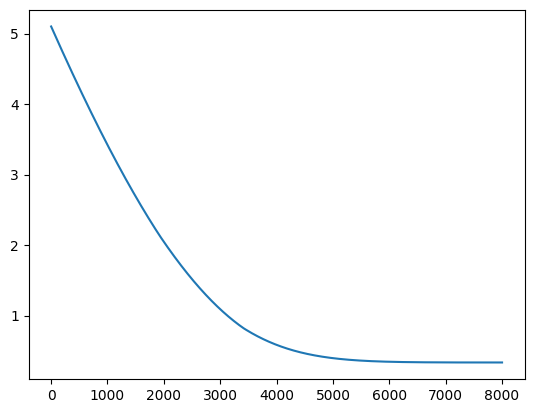

In [152]:
import matplotlib.pyplot as plt
xplot=[]
for i in range(0,len(losses)):
    xplot.append(i+1)
xplot=np.array(xplot)
plt.plot(xplot, losses)
plt.show()

In [148]:
print(k.predict(X_test))

self.sig = [0.99999834]
self.sig = [1.]
self.sig = [1.]
[[0.99999834]
 [1.        ]
 [1.        ]]


#Hyperparameter tuning

In [149]:
parameters_grid = {
    'learning_rate': [1, 0.1, 0.01],
    'batch_size': [16, 32, 64, 128],
    'loss': ['CE', 'L2'],
    'number_of_hidden_layers': [1, 2, 3],
    'number_of_neurons_per_hidden_layer': [2, 3, 5, 10],
    'epochs': [10, 50, 100]
}

max_score = 0
preferred_parameters = {}

for learning_rate in parameters_grid['learning_rate']:
  for batch_size in range(len(parameters_grid['batch_size'])):
    for loss in range(len(parameters_grid['loss'])):
      for number_of_hidden_layers in parameters_grid['number_of_hidden_layers']:
        for number_of_neurons in parameters_grid['number_of_neurons_per_hidden_layer']:
          for number_of_epochs in parameters_grid['number_of_neurons_per_hidden_layer']:

            dim = [len(X[0])]
            fun = []

            for a in range(number_of_hidden_layers):
              dim.append(number_of_neurons)
              fun.append('relu') # activation functions of hidden layers
            fun.append('sigmoid') # activation function of output layer

            network = my_Model(dim,fun,loss)
            k.train(X,y,num_epochs=number_of_epochs,learning_rate=learning_rate, batch_size=batch_size)
            score = k.score(X_test, y_test)

            if score > max_score:
                max_score = score
                preferred_parameters = {
                  'learning_rate': learning_rate,
                  'batch_size': batch_size,
                  'loss': loss,
                  'number_of_hidden_layers': number_of_hidden_layers,
                  'number_of_neurons_per_hidden_layer': number_of_neurons,
                  'epochs':number_of_epochs,
                }

print(f"Max score of {max_score} achieved at parameters: {preferred_parameters}")

ValueError: the number of layers is not equal to the number of activation funcs

#Learning Rate Scheduling

In [ ]:
class LearningRateScheduler:
  def __init__(self, decay_type, learning_rate, total_epochs):
    self.decay_type = decay_type
    self.learning_rate = learning_rate
    self.total_epochs = total_epochs

  def update_learning_rate(self, current_epoch):
    if self.decay_type == 'cosine':
      new_learning_rate = 0.5 * self.learning_rate * (1 + np.cos((current_epoch * np.pi) / self.total_epochs))
    elif self.decay_type == 'linear':
      new_learning_rate = self.learning_rate * (1 - (current_epoch / self.total_epochs))
    elif self.decay_type == 'inverse sqrt':
      new_learning_rate = self.learning_rate / np.sqrt(current_epoch)

    return new_learning_rate

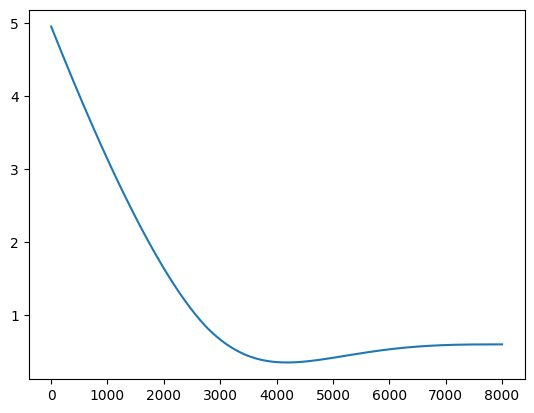